In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np

import astropy.units as u
import astropy.constants as c

import warnings

from read import read_pbh, output_specs

WDIR = os.environ['DM21CM_DIR']

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file(f"{WDIR}/matplotlibrc")

In [2]:
results_dir = '/n/home07/yitians/dm21cm/blackhawk/BlackHawk_v2.2/results'
run_name = 'm13.200_sec'

run_dir = f"{results_dir}/{run_name}"

In [3]:
evol_data = read_pbh(run_dir, 'evolution')

In [4]:
evol_data['units']

{'M0': Unit("g"),
 'rho_comov': Unit("1 / cm3"),
 't': Unit("s"),
 'dt': Unit("s"),
 'M': Unit("g")}

# 1. Energy loss rates

In [25]:
(c.hbar*c.c**4 / (15360 * np.pi * c.G**2 * evol_data['M'][300]**2 * u.g**2)).to('g/s')

<Quantity 7.35146896e+08 g / s>

In [36]:
TH = (c.hbar * c.c**3 / (8*np.pi * c.G * evol_data['M0'] * u.g)).to('eV')
TH

<Quantity 6.6708806e+08 eV>

In [37]:
sec_spec = read_pbh(run_dir, 'secondary', particle='photon')

In [44]:
sec_spec['units']

{'E': Unit("eV"), 't': Unit("s"), 'dN_dEdt': Unit("1 / (eV s)")}

In [40]:
sec_spec['dN_dEdt'].shape, sec_spec['E'].shape, sec_spec['t'].shape

((689, 500), (500,), (689,))

In [43]:
z = np.trapz(sec_spec['dN_dEdt'] * sec_spec['E'][None, :], x=sec_spec['E'], axis=-1)
z.shape

(689,)

In [34]:
[f.split('_')[0] for f in os.listdir('../../../blackhawk/BlackHawk_v2.2/results/m13.200_sec/') if 'secondary' in f and 'graviton' not in f]

['nu', 'nu', 'nu', 'proton', 'photon', 'electron']

In [35]:
def plot_spec(ax, particle, pri_or_sec, i_start=0, **kwargs):
    if particle == 'total':
        sec_spec = read_pbh(run_dir, 'primary', particle='graviton')
        spec_tot_eng = np.trapz(sec_spec['dN_dEdt'] * sec_spec['E'][None, :], x=sec_spec['E'], axis=-1)
        if pri_or_sec == 'primary':
            p_list = [f.split('_')[0] for f in os.listdir('../../../blackhawk/BlackHawk_v2.2/results/m13.200_sec/') if 'primary' in f and 'graviton' not in f]
        else:
            p_list = ['photon', 'electron', 'proton', 'nu_e', 'nu_mu', 'nu_tau']
        for p in p_list:
            sec_spec = read_pbh(run_dir, pri_or_sec, particle=p)
            spec_tot_eng += np.trapz(sec_spec['dN_dEdt'] * sec_spec['E'][None, :], x=sec_spec['E'], axis=-1)
        spec_tot_eng = (spec_tot_eng * u.eV / c.c**2).to('g').value
    else:
        sec_spec = read_pbh(run_dir, pri_or_sec, particle=particle)
        spec_tot_eng = np.trapz(sec_spec['dN_dEdt'] * sec_spec['E'][None, :], x=sec_spec['E'], axis=-1)
        spec_tot_eng = (spec_tot_eng * u.eV / c.c**2).to('g').value
    ax.plot(evol_data['t'][i_start:], spec_tot_eng[i_start:], **kwargs)

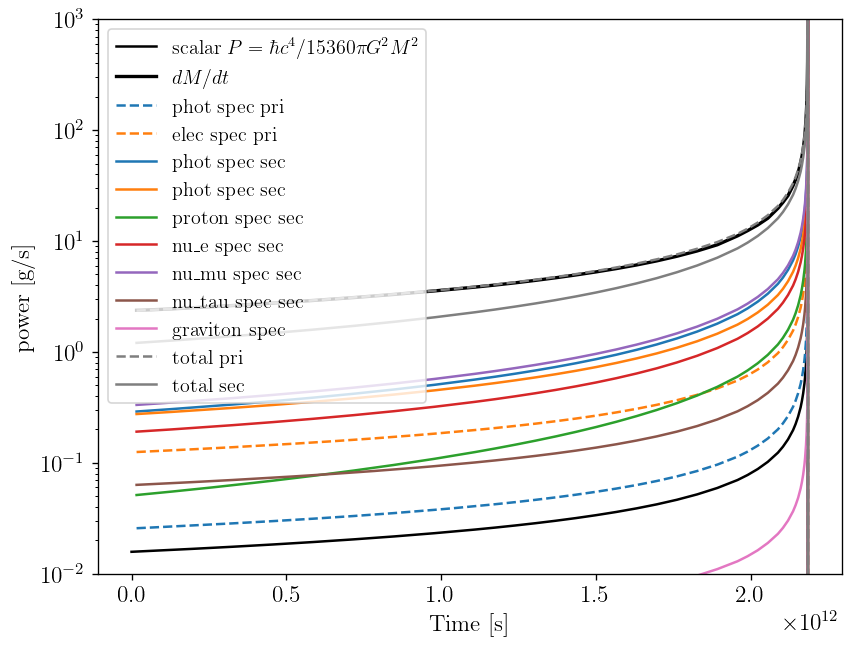

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# theory
power = (c.hbar*c.c**4 / (15360 * np.pi * c.G**2 * evol_data['M']**2 * u.g**2)).to('g/s').value
ax.plot(evol_data['t'], power, 'k', label=r"scalar $P = \hbar c^4 / 15360 \pi G^2 M^2$")

# grad(M, t)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    dMdt = np.abs(np.gradient(evol_data['M'], evol_data['t'])) # [g/s]
i_start = np.where(evol_data['t'] > 1e10)[0][0] # [s]
ax.plot(evol_data['t'][i_start:], dMdt[i_start:], color='k', label=r'$dM/dt$', lw=2)

# primary spectrum
plot_spec(ax, 'photon', 'primary', i_start=i_start, color='C0', ls='--', label='phot spec pri')
plot_spec(ax, 'electron', 'primary', i_start=i_start, color='C1', ls='--', label='elec spec pri')

# secondary spectrum
plot_spec(ax, 'photon', 'secondary', i_start=i_start, color='C0', ls='-', label='phot spec sec')
plot_spec(ax, 'electron', 'secondary', i_start=i_start, color='C1', ls='-', label='phot spec sec')

plot_spec(ax, 'proton', 'secondary', i_start=i_start, color='C2', ls='-', label='proton spec sec')
plot_spec(ax, 'nu_e', 'secondary', i_start=i_start, color='C3', ls='-', label='nu_e spec sec')
plot_spec(ax, 'nu_mu', 'secondary', i_start=i_start, color='C4', ls='-', label='nu_mu spec sec')
plot_spec(ax, 'nu_tau', 'secondary', i_start=i_start, color='C5', ls='-', label='nu_tau spec sec')
plot_spec(ax, 'graviton', 'primary', i_start=i_start, color='C6', ls='-', label='graviton spec')

# total
plot_spec(ax, 'total', 'primary', i_start=i_start, color='C7', ls='--', label='total pri')
plot_spec(ax, 'total', 'secondary', i_start=i_start, color='C7', ls='-', label='total sec')

# plotting
ax.set(yscale='log', xlabel='Time [s]', ylabel='power [g/s]')
ax.set(ylim=(1e-2, 1e3))
ax.legend()

In [48]:
from scipy import interpolate

In [50]:
np.where(sec_spec['t'] > 1e11)[0][0]

119

In [51]:
len(sec_spec['t'])

689

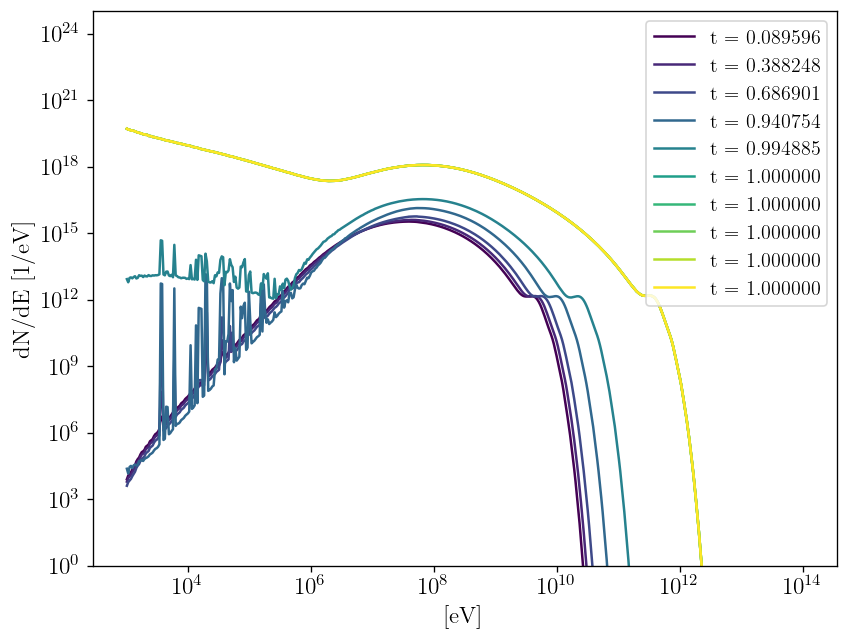

In [71]:
i_show_s = [120, 130, 140, 150, 160, 200, 300, 400, 600, 688]

spec = read_pbh(run_dir, 'secondary', particle='photon')
dNdE_interp = interpolate.interp1d(spec['t'], spec['dN_dEdt'], axis=0)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for i, i_show in enumerate(i_show_s):
    t = sec_spec['t'][i_show]
    color = cms['viridis'](i/(len(i_show_s) - 1))
    tf = sec_spec['t'][-1]
    dNdE = dNdE_interp(t)
    ax.plot(spec['E'], dNdE, color=color, label=f't = {t/tf:.6f}')
ax.set(xscale='log', yscale='log')
ax.set(ylim=(1e0, 1e25))
ax.set(xlabel='[eV]', ylabel='dN/dE [1/eV]')
ax.legend()

In [74]:
spec['E'].shape

(1000,)

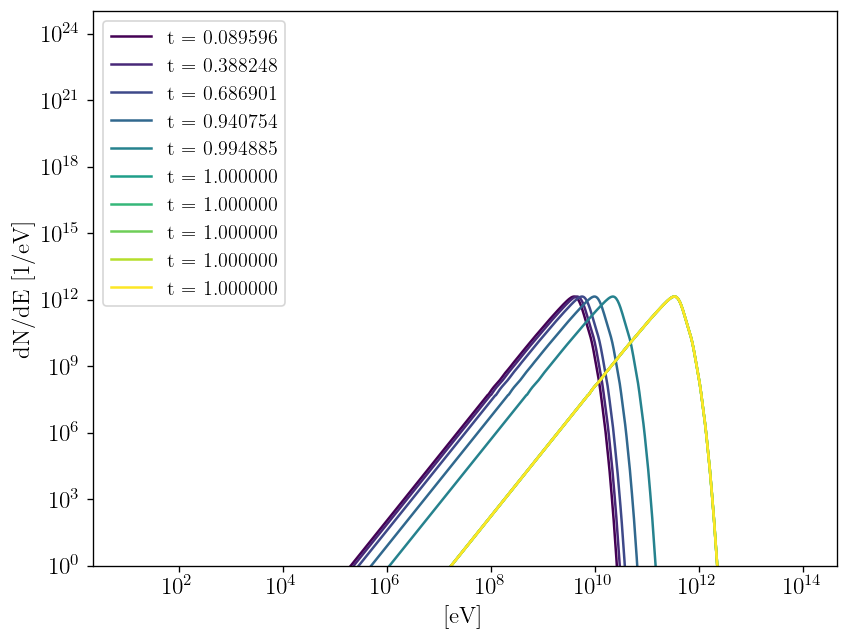

In [75]:
i_show_s = [120, 130, 140, 150, 160, 200, 300, 400, 600, 688]

spec = read_pbh(run_dir, 'primary', particle='photon')
dNdE_interp = interpolate.interp1d(spec['t'], spec['dN_dEdt'], axis=0)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for i, i_show in enumerate(i_show_s):
    t = sec_spec['t'][i_show]
    color = cms['viridis'](i/(len(i_show_s) - 1))
    tf = sec_spec['t'][-1]
    dNdE = dNdE_interp(t)
    ax.plot(spec['E'], dNdE, color=color, label=f't = {t/tf:.6f}')
ax.set(xscale='log', yscale='log')
ax.set(ylim=(1e0, 1e25))
ax.set(xlabel='[eV]', ylabel='dN/dE [1/eV]')
ax.legend()